# Image Pre-processing and Analysis to Structure Local Data Cube

This notebook aims to present one way to pre-processing images like cloud coverage analysis and download them from STAC - Spatio Temporal Asset Catalog. The Sample Assessment App code can be acessed by Github repository: [Sample Assessment App](https://github.com/AbnerErnaniADSFatec/sample-assessment).

## Methodology

This approach uses an abstraction for Earth Observation Data Cubes called `EOCubes` that allows the user to perform remote sensing image searches and create data cubes using key indexed arrays with Xarray. For this, the user needs an access code from the BDC project and, subsequently, it is necessary to select some parameters such as data collections based on the satellite image sets, an area of interest in the format of boundaries in coordinates of two points in the map, called Bounding Box, spectral bands such as near infrared or spectra look like blue, green and red, a timeline that defines a period of time from two dates and, if necessary, a limit for quantity of images in the search return.

With the definition of parameters, the package sends a request to the STAC service. This service returns a set of information with the access addresses of the images, after that the package organizes this data in an indexed structure with spatiotemporal attributes using the library Dask Delayed and Xarray.

With the object that was returned to the user, it is possible to request the visualization of data in images or matrices, allowing for a centralized search of the total set or its return. With this dataset, the user can retrieve time series and calculated spectral indices such as Normalized difference vegetation index(NDVI), Normalized difference water index (NDWI), Normalized Difference Built-up Index (NDBI) and the calculation of the color composition of the images. In this case we are going to use this libs for image data analysis:

 - [`numpy`](https://numpy.org/): it is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation, etc...;
 - [`seaborn`](https://seaborn.pydata.org/): it is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
 - [`matplotlib`](https://matplotlib.org/): it is a comprehensive library for creating static, animated, and interactive data visualizations in Python.
 - [`utils`](./utils/Python/utils.py): it is abstraction created for this project that provide the methods for download the selected images in `EO Cubes` Library.

### Imports

First step is to import all needed libraries for analysis that are listed on [`requirements.txt`](./utils/Python/requirements.txt) file:

> **Obs.:** Whereas you walk step by step from [README.md](./README.md#Material-and-Methods) or install by your own.

In [1]:
import datetime
import random
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from utils.Python.utils import Utils, Point
from eocube import DataCube, Image, Spectral, info, config

### Constants

Before we start we need to declare some constants variables like BDC user access token that can be generated using this link: [BDC Auth App](https://brazildatacube.dpi.inpe.br/auth-app/).

And we will need to declare an object of our class for `utils` with the abstraction for images download and declare the spectral variable to normalize the result of bands:

In [2]:
config.ACCESS_TOKEN = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV" # "<access_token>"
utils = Utils()
spectral = Spectral()

### Retrieving collections data cube

STAC is a standard that specifies how metadata for geospatial resources, including satellite imagery and feature files, is organized, made available, and retrieved from the web. The main objective is to carry out the cataloging of image metadata from the use of the Earth by orbital sensors.

Our abstraction for retrieving images from STAC can return a list with available collections created using satellite images from remote sensing methods:

In [3]:
info.collections()

stac("https://brazildatacube.dpi.inpe.br/stac/")

For this approach we will select the Sentinel-2 collection with spatial resolution of 10 meters and 16 days of temporal resolution using the BDC Small Grid.

This satellite was chosen because of the high definition of image and a reasonable temporal resolution:

In [4]:
info.describe("S2_10_16D_STK-1")

name,common_name,min,max,nodata,scale,data_type
EVI,evi,-10000.0,10000.0,-9999.0,0.0001,int16
NDVI,ndvi,-10000.0,10000.0,-9999.0,0.0001,int16
TOTALOB,TotalOb,1.0,255.0,0.0,1.0,uint8
band4,red,0.0,10000.0,-9999.0,0.0001,int16
band1,coastal,0.0,10000.0,-9999.0,0.0001,int16
band11,swir16,0.0,10000.0,-9999.0,0.0001,int16
band12,swir22,0.0,10000.0,-9999.0,0.0001,int16
band2,blue,0.0,10000.0,-9999.0,0.0001,int16
band5,rededge,0.0,10000.0,-9999.0,0.0001,int16
band6,rededge,0.0,10000.0,-9999.0,0.0001,int16


Now we know all the parameters for retrieve data cube from selected collection.

We will select a bounding box with coordinates of Southwest Amazon in Brazil localized in the State of Rondonia. This case study is due to the increase of land use change in this area:

<p align = "center" style = "width: 80%;">
  <img src = "./data/img/lulc_map_rondonia.png">
    <b>Figure 1: Region of Interest and the Land Use and Land Cover Map for state of Rondônia, Brazil.</b>
</p>

The select bands was chosen to identify land use and land cover classes:

|BAND      |Commom Name|Description                                                                                         |
|----------|-----------|----------------------------------------------------------------------------------------------------|
|BAND 02   |Blue       |The band comprised by the blue light spectrum                                                       |
|BAND 03   |Green      |The band comprised by the green light spectrum                                                      |
|BAND 04   |Red        |The band comprised by the red light spectrum                                                        |
|BAND 08   |NIR        |The band with Near Infra-Red that used to identify vegetation and geological features               |
|NDVI      |NDVI       |Normalized Difference Vegetation Index It is an indicator of photosynthetically active biomass      |
|EVI       |EVI        |An index designed to enhance the vegetation signal with improved sensitivity in high biomass regions|
|Fmask4    |Quality    |A band with cloud detection to calculate the cloud coverage                                         |

<p align = "center" style = "width: 80%;">
    <caption align = "center" style = "width: 60%;">
        <b>Table 1: Table with the definitions of the spectral bands used in the STAC Client search form.</b>
    </caption>
</p>

The STAC - Spatial Temporal Asset Catalog [[6]](./README.md#References) is a standard that specifies how metadata of geospatial resources, including satellite images and feature files, are organized, made available, and retrieved on the web. There is a abstraction from Brazil Data Cube - BDC called STAC Service that provides a Application Programming Interface for retrieve data from BDC data base.

The STAC Client abstraction tool was used for automatic download of images based on region of interest. To download the images using the STAC Client was necessary to fill the search form parameters as the data collection based on spectrometer satellite, the region of interest given by a bounding box, the selected spectral bands and the time span of a period.

For this approach, it was selected the Sentinel-2 MSI sensor collection with a spatial resolution of 10 meters and 16 days of temporal resolution. This satellite was chosen because of its high image definition and reasonable temporal resolution.The  bounding box of area is presented in **Figure 1.B**. The spectral bands was chosen for calculating the Normalized Difference Vegetation Index - NDVI, an indicator of photosynthetically active biomass and the Enhanced Vegetation Index - EVI for identify classes features on LULC samples [[3]](./README.md#References).

> **Obs.:** You can view the region of interest in this [`GeoJSON File`](data/shapes/region_of_interest.json) and the [Land Use and Land Cover Samples](data/samples/samples_amazonia.csv) from `SITS Data`. You can also test this coordinates using `EPSG:4326` in this link [Kenee Maps](https://www.keene.edu/campus/maps/tool/):

In [5]:
%%time
eodatacube = DataCube(
    collections = ["S2_10_16D_STK-1"],
    query_bands = ['red', 'green', 'blue', 'nir', 'evi', 'quality'],
    bbox = [-65.335, -9.849, -63.641, -11.030],
    start_date = "2018-08-12",
    end_date = "2019-07-28",
    limit = 50
)

CPU times: user 89.6 ms, sys: 18.2 ms, total: 108 ms
Wall time: 7.9 s


Well done! now we create an abstraction for our virtual data cube manipulation. Let's create a list with available dates retrieved by our data cube to facilitate the search of images.

In [7]:
dates = []
for date in list(eodatacube.data_images.keys()):
    dates.append(date.strftime("%Y-%m-%d"))
dates.reverse()
for date in dates: print(date, end=" . ")
print(f"\n\n{len(dates)} images")

2018-07-28 . 2018-08-13 . 2018-08-29 . 2018-09-14 . 2018-09-30 . 2018-10-16 . 2018-11-01 . 2018-11-17 . 2018-12-03 . 2018-12-19 . 2019-01-01 . 2019-01-17 . 2019-02-02 . 2019-02-18 . 2019-03-06 . 2019-03-22 . 2019-04-07 . 2019-04-23 . 2019-05-09 . 2019-05-25 . 2019-06-10 . 2019-06-26 . 2019-07-12 . 2019-07-28 . 

24 images


As result there are 24 images available for this region and time. If we calculate it was retrieved 2 images by month because the temporal resolution of 16 days using the best pixel approach.

### Visualizing the images

To visualize the crop image by the selected parameters we will select the first date as sample:

In [8]:
d = 0

We will calculate the NDVI Index using the formula. NDVI is defined as the difference between the reflectance of the near infrared (NIR) and red (RED) bands, divided by the sum of the two reflectances, and is expressed mathematically as:

$NDVI = \frac {NIR - RED} {NIR + RED}$

NDVI helps to differentiate vegetation from other land cover types (such as unnatural targets) and their general condition, as well as identify and classify cultivated areas in thematic maps, helping to detect changes in patterns.

In [9]:
ndvi = eodatacube.calculateNDVI(time = dates[d])
ndvi = ndvi.values[0]

Now let's visualize the ndvi image returned:

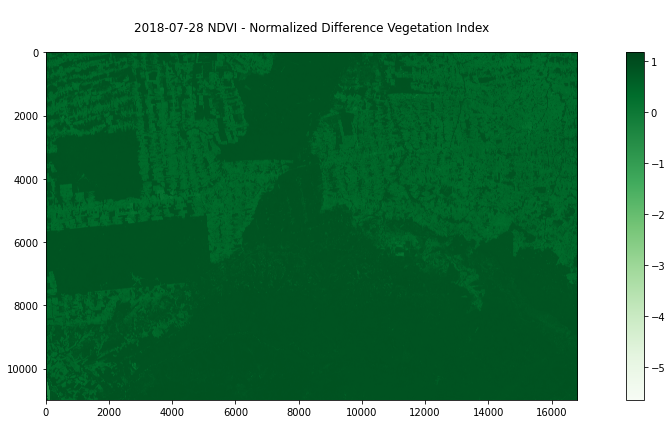

In [10]:
plt.figure(figsize=(14, 6))
colormap = plt.get_cmap('Greens', 1000)
plt.imshow(ndvi, cmap=colormap)
plt.title(f"\n{dates[d]} NDVI - Normalized Difference Vegetation Index\n")
plt.tight_layout()
plt.colorbar()
plt.show()

The crop image returned has 10.000 x 16.000 pixels because of Sentinel-2 spatial resolution of 10 meters.

It will be hard to visualize and interact with pixels, so we are make a new crop using the function `cut_square_image` implemented by our script in file [`utils`](./utils/Python/utils.py).

First we will define some constraints to crop image like minimum and maximum value for xy axis.

This values will cut the image to analysis:

In [13]:
min_x, max_x = 6000, 10000
min_y, max_y = 2000, 6000
ndvi_crop = utils.cut_square_image(ndvi, min_x, max_x, min_y, max_y)

And now let's visualize the cropped image 4000 x 4000 pixels:

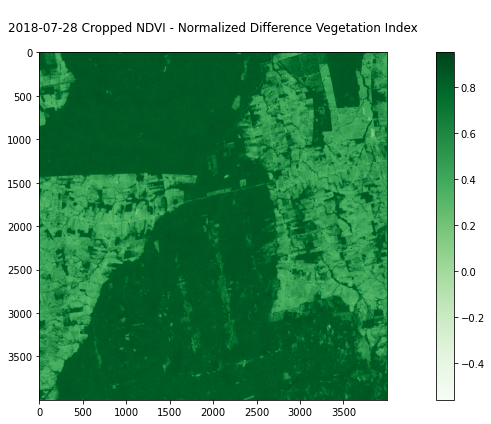

In [17]:
plt.figure(figsize=(14, 6))
colormap = plt.get_cmap('Greens', 1000)
plt.imshow(ndvi_crop, cmap=colormap)
plt.title(f"\n{dates[d]} Cropped NDVI - Normalized Difference Vegetation Index\n")
plt.tight_layout()
plt.colorbar()
plt.show()

To visualize a colored composition, you need to inform which bands will be used in the Red, Green and Blue components. For this, we can create a NumPy matrix with 3 dimensions (rows, columns, bands).

But before we will need to crop the images based on minimum and maximum values showed on NDVI calculus and the same date selected:

In [18]:
# Search red band from data cube
red = eodatacube.select(band="red", time=dates[d])
red = red.values[0]
# Cropping the image
red_crop = utils.cut_square_image(red, min_x, max_x, min_y, max_y)
# Search green band from data cube
green = eodatacube.select(band="green", time=dates[d])
green = green.values[0]
# Cropping the image
green_crop = utils.cut_square_image(green, min_x, max_x, min_y, max_y)
# Search blue band from data cube
blue = eodatacube.select(band="blue", time=dates[d])
blue = blue.values[0]
# Cropping the image
blue_crop = utils.cut_square_image(blue, min_x, max_x, min_y, max_y)

Now we will create a visualization of color composition image with a three dimensional array.

We are using normalization for build the color image implemented by Spectral class in EO Data Cubes:

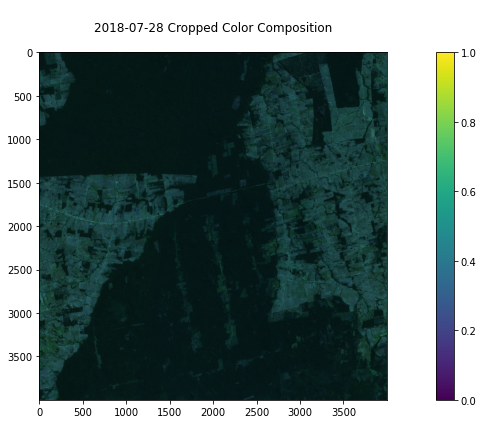

In [25]:
rgb_crop = np.dstack(
    (spectral._normalize(red_crop), spectral._normalize(green_crop), spectral._normalize(blue_crop))
)
plt.figure(figsize=(14, 6))
plt.title(f"\n{dates[d]} Cropped Color Composition\n")
plt.imshow(rgb_crop)
plt.colorbar()
plt.tight_layout()
plt.show()

### Analysing Histogram

An RGB histogram is produced when the computer scans the image at each of these RGB brightness values and counts how many pixels there are at each level from 0 to 255. Other types of histograms exist, but they all look more or less the same as the example below.

In this step we will analyse the histogram of the returned images.

First we will generate the NDVI histogram to visualize the distribution of values:

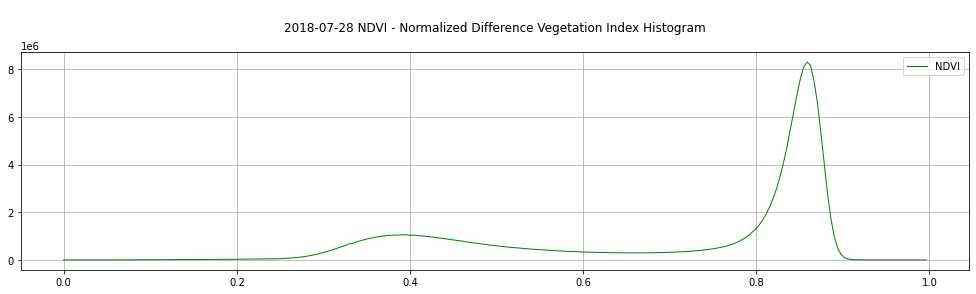

In [33]:
histogram, bin_edges = np.histogram(ndvi, bins=255, range=(0, 1))
plt.figure(figsize=(17,4))
plt.title(f"\n{dates[d]} NDVI - Normalized Difference Vegetation Index Histogram\n")
plt.plot(bin_edges[0:-1], histogram, color="green", linewidth=1, label='NDVI')
plt.legend()
plt.grid()
plt.show()

Using the same technique we will generate the histogram for RGB Image:

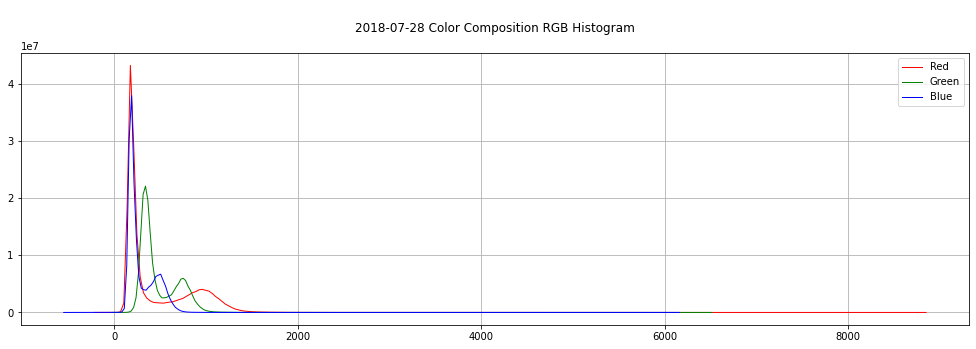

In [38]:
red_hist, red_bin_edges = np.histogram(red, bins=255)
green_hist, green_bin_edges = np.histogram(green, bins=255)
blue_hist, blue_bin_edges = np.histogram(blue, bins=255)
plt.figure(figsize=(17,5))
plt.title(f"\n{dates[d]} Color Composition RGB Histogram\n")
plt.plot(red_bin_edges[0:-1], red_hist, color="red", linewidth=1, label='Red')
plt.plot(green_bin_edges[0:-1], green_hist, color="green", linewidth=1, label='Green')
plt.plot(blue_bin_edges[0:-1], blue_hist, color="blue", linewidth=1, label='Blue')
plt.legend()
plt.grid()
plt.show()

We can conclude that the image has low contrast as the values are centered to the right where the grey values are local.

Although the contrast do not help to analyse or classify the images.

### Cloud coverage

Cloud cover can be a problem in the spectral indices calculation, as the time series can contain a worthless point, which means that a cloud is passing through the spectrometer and the object of study. To identify the clouds, high values for the cloud mask "Fmask4"were used to classify the dates with clouds that influence the NDVI output values.

Interpolation is a type of estimation, a method of constructing new data points based on the range of a discrete set of known data points [[7]](./README.md#References). The simple interpolation method was used for fill the nodata values implemented by the SITS - Satellite Image Time Series package in R programming language [[8]](./README.md#References).

Due to the growing use of remote sensing images for land use and land cover classification. Studies related to the identification and smoothing of cloud cover have also increased.

Cloud cover can be a problem in time series analysis because the time series can contain a worthless point, which means that a cloud is passing through the spectrometer and the object of study.

In this step, we will analyze the cloud cover of the images retrieved by STAC.

For this, we will need to research images with high cloud cover to analyze. We will iterate over all the images and look for high detection values of `Fmask4` identified by band commom name `quality`:

In [139]:
selected = None
date_selected = None
_max = 0
for date in dates:
    cloud = eodatacube.select(band = "quality", time = date)
    cloud = cloud.values[0]
    counts = (cloud >= 3).sum()
    if counts >= _max:
        _max = counts
        selected = cloud
        date_selected = date
print(date_selected)

2019-01-01


The time with the biggest cloud coverage is about 2019 January 1 for this case study and you can see below the image with cloud mask in 4 levels of grey:

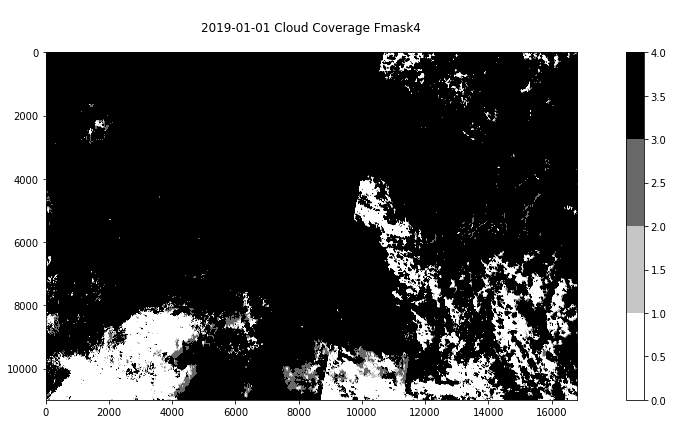

In [140]:
plt.figure(figsize=(14, 6))
colormap = plt.get_cmap('Greys', 4)
plt.imshow(selected, cmap=colormap)
plt.title(f"\n{date_selected} Cloud Coverage Fmask4\n")
plt.tight_layout()
plt.colorbar()
plt.show()

Let's visualize the RGB histogram:

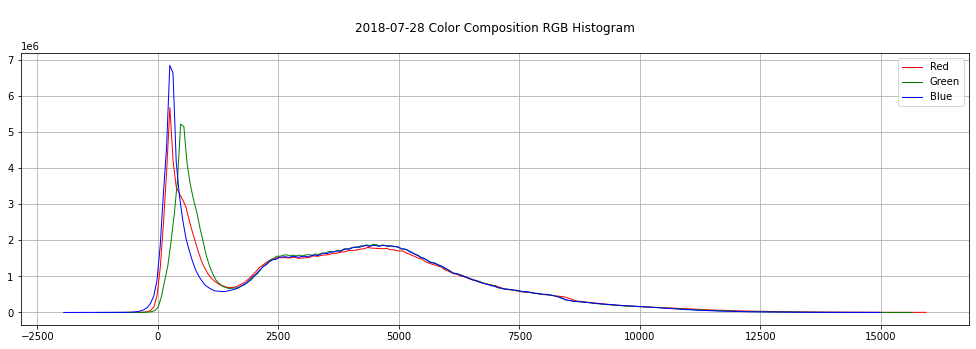

In [141]:
# Search red band from data cube
red = eodatacube.select(band="red", time=date_selected)
red = red.values[0]
# Search green band from data cube
green = eodatacube.select(band="green", time=date_selected)
green = green.values[0]
# Search blue band from data cube
blue = eodatacube.select(band="blue", time=date_selected)
blue = blue.values[0]
red_hist, red_bin_edges = np.histogram(red, bins=255)
green_hist, green_bin_edges = np.histogram(green, bins=255)
blue_hist, blue_bin_edges = np.histogram(blue, bins=255)
plt.figure(figsize=(17,5))
plt.title(f"\n{date_selected} Color Composition RGB Histogram\n")
plt.plot(red_bin_edges[0:-1], red_hist, color="red", linewidth=1, label='Red')
plt.plot(green_bin_edges[0:-1], green_hist, color="green", linewidth=1, label='Green')
plt.plot(blue_bin_edges[0:-1], blue_hist, color="blue", linewidth=1, label='Blue')
plt.legend()
plt.grid()
plt.show()

Now let's create a view for this cloud coverage data.

We know that clouds directly affect the data and causes disturbance in spectral indices calculus. Below there is a code that select and calculate the data about this image with the biggest cloud coverage:

In [149]:
# Definição dos mínimos e máximos
min_x, max_x = 0, 4000
min_y, max_y = 6000, 10000

# Cálculo do RGB
red_crop = utils.cut_square_image(red, min_x, max_x, min_y, max_y)
green_crop = utils.cut_square_image(green, min_x, max_x, min_y, max_y)
blue_crop = utils.cut_square_image(blue, min_x, max_x, min_y, max_y)
rgb_crop = np.dstack(
    (spectral._normalize(red_crop), spectral._normalize(green_crop), spectral._normalize(blue_crop))
)

# Cálculo do NDVI
ndvi = eodatacube.calculateNDVI(time=date_selected)
ndvi = ndvi.values[0]
ndvi_crop = utils.cut_square_image(ndvi, min_x, max_x, min_y, max_y)

# Recuperando a banda NIR
nir = eodatacube.select(band="nir", time=date_selected)
nir = nir.values[0]
nir_crop = utils.cut_square_image(nir, min_x, max_x, min_y, max_y)

# Recortando a máscara de nuvem
cloud_crop = utils.cut_square_image(selected, min_x, max_x, min_y, max_y)

Below there is an visualization to cloud coverage in different bands like NIR and RGB Color Composition.

For this use case we only want to get time series but the clouds are in the way.

To resolve this problem we need to create a data interpolation method...

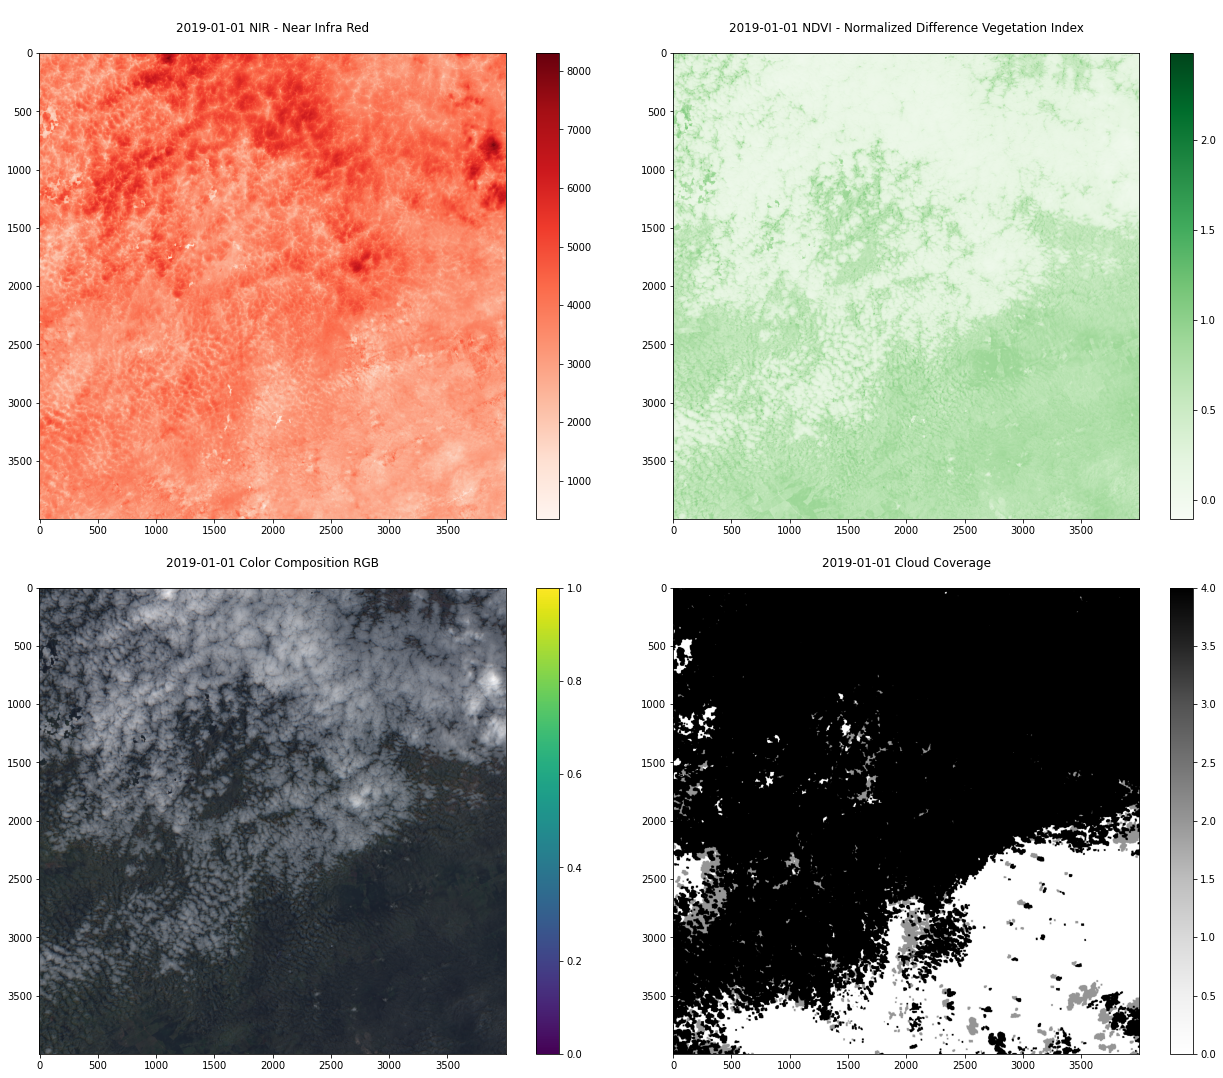

In [153]:
# Criando a visualização
fig, axs = plt.subplots(2, 2, figsize=(18, 15))
steps = 1000

colormap = plt.get_cmap('Reds', steps)
img = axs[0][0].imshow(nir_crop, cmap=colormap)
axs[0][0].set_title(f'\n{date_selected} NIR - Near Infra Red\n')
fig.colorbar(img, ax=axs[0][0])

colormap = plt.get_cmap('Greens', steps)
img = axs[0][1].imshow(ndvi_crop, cmap=colormap)
axs[0][1].set_title(f'\n{date_selected} NDVI - Normalized Difference Vegetation Index\n')
fig.colorbar(img, ax=axs[0][1])

img = axs[1][0].imshow(rgb_crop)
axs[1][0].set_title(f'\n{date_selected} Color Composition RGB\n')
fig.colorbar(img, ax=axs[1][0])

colormap = plt.get_cmap('Greys', steps)
img = axs[1][1].imshow(cloud_crop, cmap=colormap)
axs[1][1].set_title(f'\n{date_selected} Cloud Coverage\n')
fig.colorbar(img, ax=axs[1][1])

fig.tight_layout()
plt.show()

### Time Series Interpolation

When you are handle with clouds or any disturbance in sensors you can lost data, but there is a solution for this case called interpolation.

The interpolation method is a type of estimation, a method of constructing new data points based on the range of a discrete set of known data points.

Let's test data interpolation in our use case. For this we need to select some samples and locate the nodata values in its time series.

Below there is a line that will read the samples data file and it will select one sample from each class:

In [160]:
samples = pd.read_csv("./data/samples/samples_amazonia.csv")
samples.head(3)

,id,longitude,latitude,start_date,end_date,label
0,1,-64.694480,-9.986312,2018-07-12,2019-07-28,Deforestation
1,2,-64.629794,-9.996668,2018-07-12,2019-07-28,Deforestation
2,3,-64.521625,-9.979772,2018-07-12,2019-07-28,Deforestation


We need to count the classess to select a random sample:

In [162]:
classes = list(set(samples["label"]))
print(f"It was found {len(classes)} classes!\n")
print(classes)

It was found 4 classes!

['Forest', 'NatNonForest', 'Pasture', 'Deforestation']


To select a random class we need to struct them in a dictionary and finally we can select the random sample::

In [176]:
random_samples = {}
for _class in classes:
    lines = samples[samples.label == _class]
    random_line = lines.iloc[
        random.randint(0, len(lines))
    ]
    random_samples[_class] = random_line

And now we will select the NIR - Near Infra Red time series for each random sample:

In [212]:
classes = ["Pasture"]
time_series = {}
for _class in classes:
    try:
        ts = eodatacube.getTimeSeries(
            band='nir',
            lon=random_samples[_class]["longitude"],
            lat=random_samples[_class]["latitude"]
        )
        cmask = eodatacube.getTimeSeries(
            band='quality',
            lon=random_samples[_class]["longitude"],
            lat=random_samples[_class]["latitude"]
        )
    except:
        ts, cmask = None, None
    time_series[_class] = {
        "nir": ts,
        "cmask": cmask
    }

As a result we get the response as Xarray.

This Xarray contains all time series data from each LULC class:

In [215]:
time_series['Pasture']['nir']

<xarray.DataArray ['TimeSeries_NIR'] (time: 23)>
array([2102, 2311, 2799, 3120, 2831, 4757, 7158, 3809, 3741, 4449, 2580,
       2313, 3297, 2656, 2010, 2114, 3148, 2118, 1882, 1649, 1622, 1791,
       2091], dtype=int16)
Coordinates:
  * time     (time) datetime64[ns] 2018-08-13 2018-08-29 ... 2019-07-28
Attributes:
    longitude:  -65.2431919006644
    latitude:   -10.4015215581636

To identify the clouds in time series we need to classify the dates with high values for cloud mask.

We know the cloud mask nodata value is about number 4 as we saw in the collection information above in the creation of data cube.

This step is about classify the nodata values in time series and add a straight line in vertical:

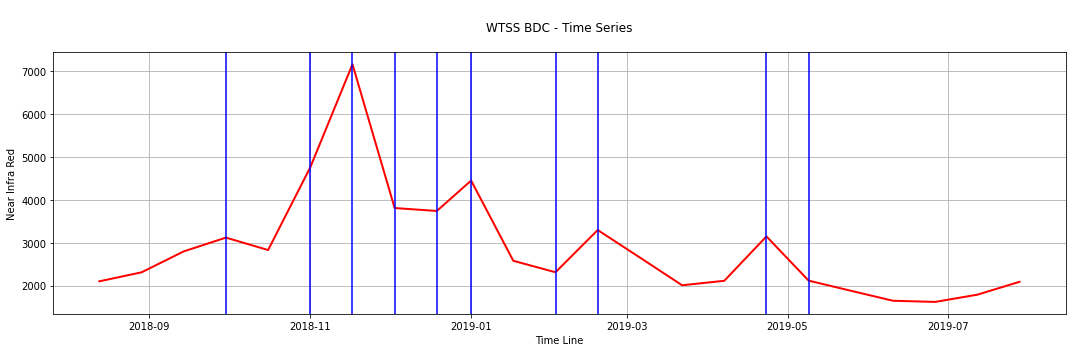

In [258]:
_class = "Pasture"

ts = time_series[_class]['nir']
cmask = time_series[_class]['cmask']
time_line = ts.time
values = ts
cmask_values = cmask
x_cmask = []
noise = []
clean_ts = []
time_clean_ts = []

for i in range(len(cmask_values)):
    if cmask_values[i].values >= 4:
        x_cmask.append(time_line[i].values)

for i in range(len(time_line)):
    value = False
    for j in range(len(x_cmask)):
        if time_line[i].values == x_cmask[j]:
            value = ts[i].values
    if value:
        noise.append(value)

for i in range(len(time_line)):
    value = values[i].values
    if value not in noise:
        clean_ts.append(value)
        time_clean_ts.append(datetime.datetime.strptime(dates[i], '%Y-%m-%d'))

plt.figure(figsize=(15,5))
plt.title(f"\nWTSS BDC - Time Series\n")
plt.xlabel('Time Line')
plt.ylabel('Near Infra Red')
plt.plot(time_line, values, color="red", linewidth=2)
for i in range(len(x_cmask)):
    plt.axvline(x = x_cmask[i], color='blue', linestyle='-')
plt.tight_layout()
plt.grid()
plt.show()

In this example there are many dates that are nodata because of cloud coverage.

The blue lines are the points where a cloud has occurred.

We can clean up this dataset by eliminating those values that might influence our research and estimating the null values with a simple interpolation.

Below is the clean time series without the data that was under the influence of cloud coverage.

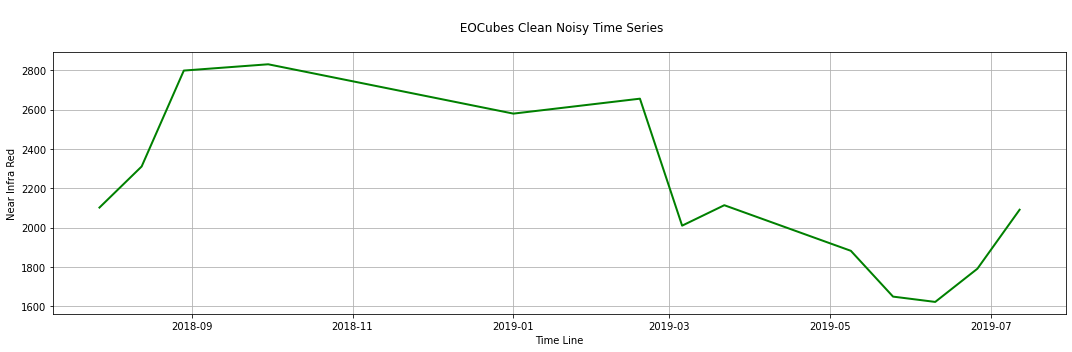

In [259]:
plt.figure(figsize=(15,5))
plt.title(f"\n EOCubes Clean Noisy Time Series\n")
plt.xlabel('Time Line')
plt.ylabel('Near Infra Red')
plt.plot(time_clean_ts, clean_ts, color="green", linewidth=2)
plt.tight_layout()
plt.grid()
plt.show()

Below is the code for the simple interpolation containing the necessary parameters for the interpolation:

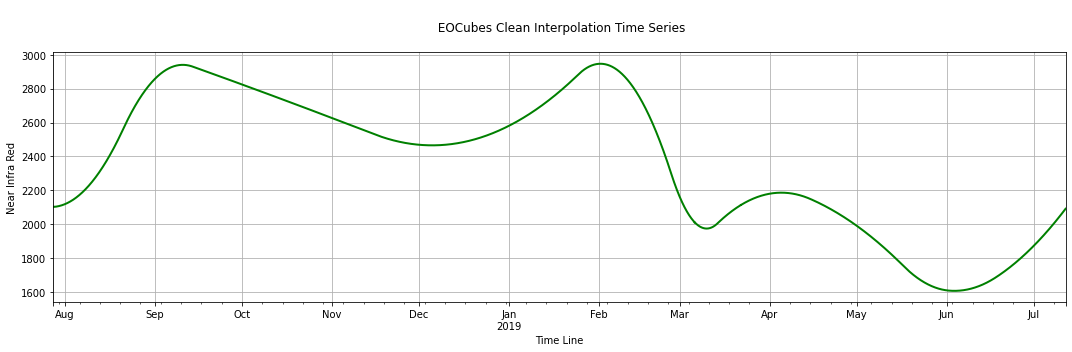

In [280]:
ts = pd.Series(clean_ts, index=time_clean_ts)
ts[ts==-1] = np.nan
ts = ts.resample('T').mean()
plt.figure(figsize=(15,5))
plt.title(f"\n EOCubes Clean Interpolation Time Series\n")
plt.xlabel('Time Line')
plt.ylabel('Near Infra Red')
ts.interpolate(method = 'spline', order = 2).plot(color="green", linewidth=2)
plt.tight_layout()
plt.grid()
plt.show()

When the interpolation is in excess this can cause classification failures. For example, if half of the dataset is interpolated, they can generate unexpected results in the classification and even non-true results.

When it is necessary to interpolate some of the data it can be a good solution.

### Region Growning

Segmentation based on region growth is a procedure that aggregates pixels with similar properties into regions.

A simple approach is to start with a set of pixels called seeds and, from them, grow the regions by attaching to each seed point other pixels that have similar properties. Seed pixels can be chosen randomly, deterministically or selected by the user.

In this algorithm, one region is obtained at a time, adding pixels from the use of seeds. With the seed pixel representing region R, as long as there is a neighboring pixel Vi of R such that P (R U Vi) = True, include Vi in R and update the attribute neighborhood. Repeat the previous steps while there are seeds. P (R U Vi) in this case is the Euclidean distance.

_"In mathematics, Euclidean distance (or metric distance) is the distance between two points, which can be proved by the repeated application of Pythagoras' theorem. Applying this formula as a distance, Euclidean space becomes a metric space."_

We will give a brief example of how land use and land cover samples can be used for the region growth algorithm.

Let's select a band with the maximum and minimum values defined in the cutout above:

In [286]:
nir = eodatacube.select(band="nir", time=(dates[len(dates) - 1]))
nir = nir.values[0]
nir = utils.cut_square_image(nir, min_x, max_x, min_y, max_y)

Let's preview the returned image:

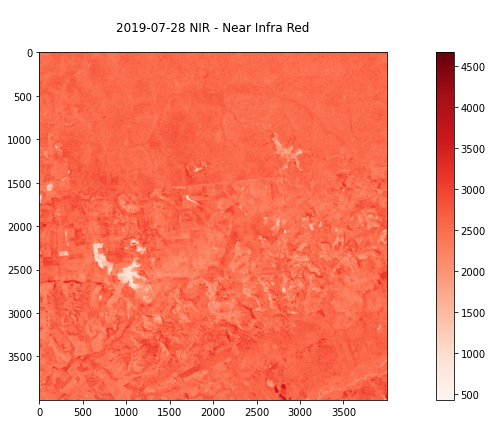

In [287]:
plt.figure(figsize=(14, 6))
colormap = plt.get_cmap('Reds', 1000)
plt.imshow(nir, cmap=colormap)
plt.title(f"\n{(dates[len(dates) - 1])} NIR - Near Infra Red\n")
plt.tight_layout()
plt.colorbar()
plt.show()

To collect the seeds we will select a sample of each land use and land cover class that the returned image contains.

For this, we will use the affine function to convert the points in geographic coordinates into points in the Cartesian plane of the image:

In [314]:
classes = list(set(samples["label"]))
sample_img = eodatacube.data_images[datetime.datetime(2019, 1, 1, 0, 0)]
classes_read = {}
for _class in classes:
    data_class = samples[samples.label == _class]
    for i in range(len(data_class)):
        data_class_value = data_class.iloc[i,]
        lon = data_class_value["longitude"]
        lat = data_class_value["latitude"]
        try:
            y, x = sample_img._afimCoordsToPoint(lon, lat, "nir")
            y, x = y - abs(max_y - min_y), x - abs(max_x - min_x)
            value = nir[y][x]
            if value and _class not in list(classes_read.keys()):
                classes_read[_class] = {
                    "data": data_class_value,
                    "point": (y, x)
                }
        except:
            pass

Now let's convert the points we collected into seeds for the region growing algorithm implemented by the script in the [`utils`](./utils/Python/utils.py) file:

In [324]:
seeds = []
for _class in classes:
    data_class_value = classes_read[_class]
    y, x = data_class_value["point"]
    seeds.append(Point(x, y))

Now we can segment the returned image with the seeds:

In [342]:
segmentation = utils.regionGrow(nir, seeds, 70)

Depending on the amount of seeds and regions this step may take a while. But we can see the segmented image below:

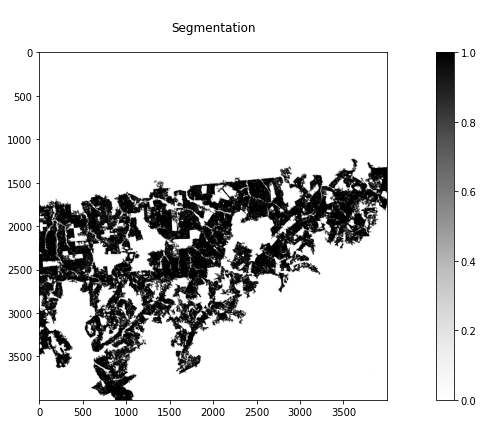

In [343]:
plt.figure(figsize=(14, 6))
colormap = plt.get_cmap('Greys', 1000)
plt.imshow(segmentation, cmap=colormap)
plt.title(f"\nSegmentation\n")
plt.tight_layout()
plt.colorbar()
plt.show()

### Downloading Images

With the analysis of the images completed, we can download the files directly from the BDC STAC API.

With the code below we can download the images automatically with the method implemented by the [`utils`](./utils/Python/utils.py) file:

In [14]:
# Renomear os arquivos de acordo com a configuração do SITS exemplo
# ./data/config.yml
utils.download_bands(
    eodatacube,
    path = "data/raster",
    satellite = "Sentinel-2",
    bands = ["NDVI", "EVI", "band4", "band3", "band2", "band8", "Fmask4"],
    start_date = "2018-01-01",
    end_date = "2019-08-31"
)

## Conclusion

With the downloaded images the SITS R Package can be used to structure the images in a local data cube. This tool provides a set of methods for the time series analysis from satellite imagery. The main functionality of the SITS package is support for the classification of land use and land cover changes in satellite imagery [[8]](./README.md#References). With the SITS, time series were extracted to carry out an exploratory analysis of the data, evaluating the quality of the data and forming a new data set.

The approach DataScience for LULC Classification with Exploratory Time Series Analysis demonstrates to conduct a study on exploratory analysis in LULC using time series collected from remote sensing images using data extraction tools such as SITS in R language. This study on LULC classification patterns that identify a certain class, these patterns can be found by time series characteristics associated with statistical methods and data mining techniques. The jupyter notebook used for reading and structuring the images can be accessed through this link [DataScience](./DataScienceCAP394TrabalhoFinalAbnerAnjos.ipynb) with scripts in R.

[REFERENCES](./README.md#References)